# Entrainement et utilisation de DDPM et CFG

Dans ce notebook, on s'occupe de construire et entraîner un modèle de diffusion semblable décrit dans l'article de recherche "Denoising Diffusion Probabilistic Models" [[Ho et al., 2020]](https://arxiv.org/pdf/2006.11239). Dans l'implémentation originale, les auteurs ont utilisés Tensorflow. Ici, nous proposons une implémentation de zéro avec Pytorch.

On ajoute aussi la notion de Classifier-Free Diffusion Guidance (GFG) issu de l'article de recherche [[Ho et Salimans, 2022]](https://arxiv.org/pdf/2207.12598).

Nous avons choisi d'utiliser le dataset FashionMNIST pour réaliser nos tests. En terme de GPU, nous utilisons un NVIDIA Tesla 4.

À la suite de ce notebook, l'objectif est d'utiliser les poids sauvegardés afin d'effectuer de la génération et de la reconstruction d'images (inpainting) au moment de l'inférence.

## Architecture du modèle

## Définitions & Dataset

On s'occupe de définir le data loader Pytorch pour chager nos données et utiliser pleinement les notions de batch pendant l'entrainement.

In [1]:
import torch
from torchvision import datasets, transforms

# Dinition du batch size pour l'entrainement
batch_size = 128

# Transformation des images : flip horizontal aléatoire, conversion en tenseur, padding de 2 pixels pour obtenir des images 28x28 -> 32x32 (pour obtenir des dimensions compatibles avec le modèle en puissance de 2, plus simple pour les calculs)
fn_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Pad(2),
])

# Chargement des datasets FashionMNIST pour l'entrainement et le test
dataset = datasets.FashionMNIST(
    "../data",
    train=True,
    download=True,
    transform=fn_transform
)

# Et le test
dataset_test = datasets.FashionMNIST(
    "../data",
    train=False,
    download=True,
    transform=fn_transform
)

# Création des data loaders pour l'entrainement et le test
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

# Mappage entre les labels numériques et les noms des classes
label_to_name_map = {
    0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot",
}
name_to_label_map = {
    name: label for label, name in label_to_name_map.items()
}

num_classes = len(label_to_name_map)

Nous voulons vérifier un sample par classe pour avoir de l'intuition sur notre dataset. On utilise les scripts python que l'on a placé dans le dossier `scripts/`. Dans ces scripts, on retrouve notamment le code pour la visualisation et des blocs du réseau de neuronnes afin de ne pas saturer les notebooks pour garder les idées au clair.

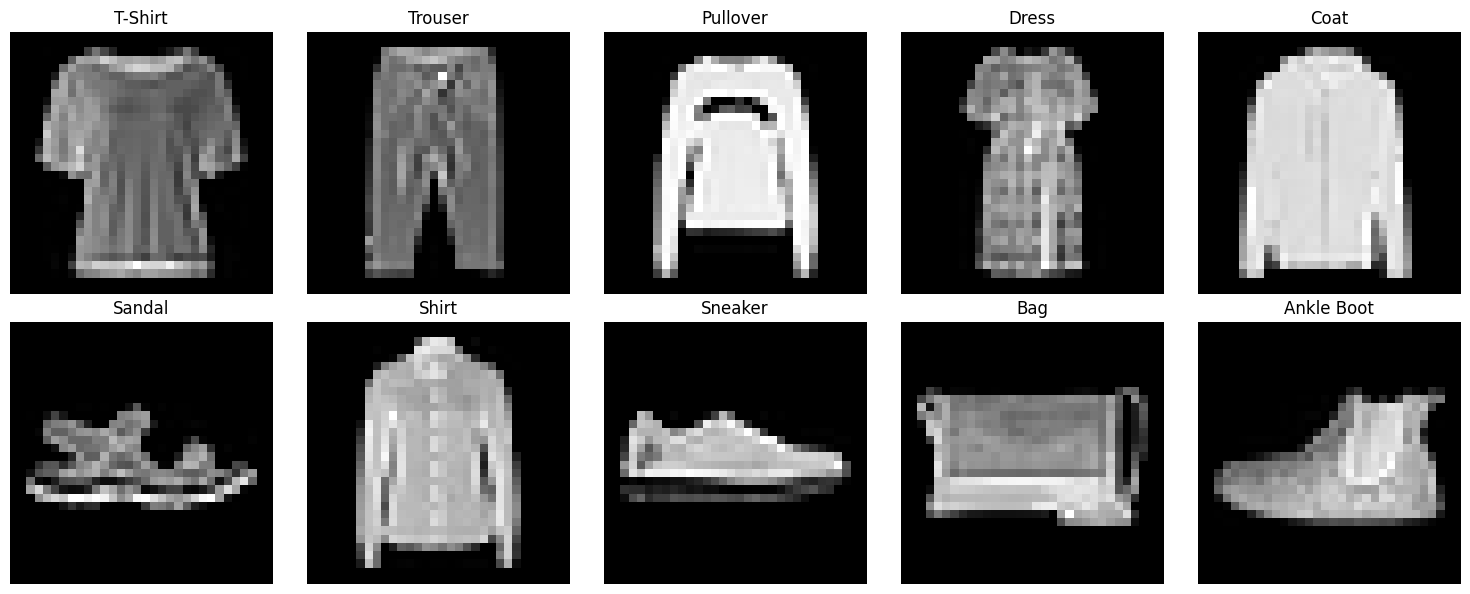

In [2]:
from scripts.visualization import visualize_fashion_mnist_classes

tmp_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
visualize_fashion_mnist_classes(tmp_loader, label_to_name_map)

Définition du device pour pytorch. Nous avons entrainé à la fois sur MPS (macbook bien trop long..) et sur GPU avec CUDA (bien mieux!).

In [3]:
from scripts.nn_blocks import device

print(f"Device utilisé actuellement: {device}")

Device utilisé actuellement: mps


## Entrainement

In [4]:
import torch
import torch.nn as nn
from scripts.u_net import UNet

# On retrouve ici le batch size comme première dimension des tenseurs
unet_base_channel = 128

# Création du modèle UNet conditionné sur les classes
# On embed les classes dans un espace de dimension unet_base_channel*4
emb = nn.Embedding(num_classes, unet_base_channel*4).to(device)

# Création du modèle UNet
# Tout le détail du modèle se trouve dans le fichier python cripts/u_net.py
# Fashion MNIST ayant des images en niveaux de gris, on utilise une seule channel en entrée
unet = UNet(
    source_channel=1,
    unet_base_channel=unet_base_channel,
    num_norm_groups=32,
).to(device)

Pour avoir une certaine intuition sur les dimensions et vérifier en partie la validité de l'implémentation de notre modèle, on passe un batch à travers le modèle.

In [5]:
batch, labels = next(iter(tmp_loader))
t = torch.randint(0, 1000, (batch.size(0),)).to(device)
out = unet(batch.to(device), t, emb(labels.to(device)))
# Parfait, les dimensions correspondent bien!
t.shape, batch.shape, labels.shape, out.shape

(torch.Size([128]),
 torch.Size([128, 1, 32, 32]),
 torch.Size([128]),
 torch.Size([128, 1, 32, 32]))

Ici, on définit l'ensemble des paramètres nécessaire pour implémenter la boucle d'entrainement du modèle à savoir:

- $p_{uncond}=0.2$: définit la probabilité de dropout de la classe de conditionnement. Par exemple, dans 20% des cas, on génère ainsi une prédiction non conditionnée à partir d'une image bruitée $x_t$. Cela permet au modèle d'apprendre aussi la distribution générale des données présentes dans le dataset.
- $\bar \alpha$: permet de contrôler l'ajout de bruit ajouté à l'image d'origine $x_0$ en fonction de la step $t$. On utilise ainsi la formule suivante: $x_t = \sqrt{\bar \alpha}x_0 + \sqrt{1 - \bar\alpha} \epsilon$ avec $\epsilon \sim N(0;1)$. On calcule directement tous les $\bar\alpha$ possibles avant entraînement, d'où les plusieurs définitions de variables ci-dessous relatives aux alphas.

En terme d'optimiseur, on utilise un Adam classique avec un learning rate scheduler linéaire (de $1e^{-8}$ à $2e^{-4}$).

In [ ]:
p_uncond = 0.2

opt = torch.optim.Adam(list(emb.parameters()) + list(unet.parameters()), lr=2e-4, eps=1e-08)
scheduler = torch.optim.lr_scheduler.LinearLR(
    opt,
    start_factor=1.0/5000,
    end_factor=1.0,
    total_iters=5000)

T = 1000
alphas = torch.linspace(start=0.9999, end=0.98, steps=T, dtype=torch.float32).to(device)
alpha_bars = torch.cumprod(alphas, dim=0)
sqrt_alpha_bars_t = torch.sqrt(alpha_bars)
sqrt_one_minus_alpha_bars_t = torch.sqrt(1.0 - alpha_bars)

num_epochs = 100

On définit d'abord l'évaluation du modèle sur l'ensemble de test. Cela nous permet d'observer la convergence de notre modèle sur des données non vues lors de l'entrainement. Le code ci-dessous n'est volontairement pas commenté car il est extrêmement similaire à la boucle d'entrainement qui elle l'est.

In [7]:
from tqdm import tqdm
import torch.nn.functional as F

def run_eval_test():
    unet.eval()
    emb.eval()

    with torch.no_grad():
        test_epoch_loss = []
        loop = tqdm(loader_test, leave=True)

        for batch_idx, (data, y) in enumerate(loop):
            x_0 = data.to(device)
            y_ = y.to(device)

            b = x_0.size(dim=0)
            t = torch.randint(T, (b,)).to(device)

            eps = torch.randn_like(x_0).to(device)

            x_t = sqrt_alpha_bars_t[t][:,None,None,None].float() * x_0 + sqrt_one_minus_alpha_bars_t[t][:,None,None,None].float() * eps
            y_emb = emb(y_)

            rnd = torch.rand(b).to(device)
            mul = torch.where(rnd < p_uncond, 0.0, 1.0)
            y_emb = y_emb * mul[:,None]

            model_out = unet(x_t, t, y_emb)
            loss = F.mse_loss(model_out, eps, reduction="mean")

            test_epoch_loss.append(loss.item())
            loop.set_postfix(loss=loss.item())

        epoch_average_loss = sum(test_epoch_loss)/len(test_epoch_loss)
        print(f"Evaluation sur l'ensemble de test fini. Avg Loss: {epoch_average_loss:.4f}")

        return epoch_average_loss

On définit ici la boucle d'entraînement. On fait N épochs sur la totalité du dataset. On répertorie les valeurs des fonctions de perte pour les phases d'entraînement et de test (sur les deux sous-ensembles du datasets).

In [ ]:
import pickle

train_epoch_loss = []
test_epoch_loss = []

for epoch_idx in range(num_epochs):
    print(f"Epoch {epoch_idx+1}/{num_epochs}")
    # TQDM nous permet d'avoir une barre de progression sympa
    loop = tqdm(loader, leave=True)

    current_train_epoch_loss = 0

    # On itère sur les batches du DataLoader (469 batches X 128 images ~ 60000 images)
    for batch_idx, (data, y) in enumerate(loop):
        unet.train()
        opt.zero_grad()

        # Image originale
        x_0 = data.to(device)
        # Label de classe: entier entre 0 et 9
        y_ = y.to(device)

        b = x_0.size(dim=0)

        # Tirage aléatoire du timestep t pour chaque image du batch
        # Cela parmet d'entrainer le modèle sur tous les timesteps et d'éviter l'overfitting sur certains
        # timesteps. Le modèle ne plonge ainsi pas dans une "zone de confort" pour certains timesteps.
        # Tirage uniforme entre 0 et T-1
        t = torch.randint(T, (b,)).to(device)

        # Bruit aléatoire suivant une distribution normale centrée réduite
        eps = torch.randn_like(x_0).to(device)

        # Génération de l'image bruitée au timestep t
        # On utilise la formule de diffusion directe vue en cours
        # Cela correspond à l'ajout de bruit gaussien à l'image originale selon le timestep t
        # grâce aux alpha_bars pré-calculés
        # Plus t est grand, plus l'image est bruitée
        x_t = sqrt_alpha_bars_t[t][:,None,None,None].float() * x_0 + sqrt_one_minus_alpha_bars_t[t][:,None,None,None].float() * eps
        y_emb = emb(y_)

        # Application du dropout conditionnel sur les embeddings de classes, essentiel pour le classifier-free guidance
        rnd = torch.rand(b).to(device)
        mul = torch.where(rnd < p_uncond, 0.0, 1.0)
        y_emb = y_emb * mul[:,None]

        # Prédiction du bruit par le modèle UNet
        model_out = unet(x_t, t, y_emb)
        # Calcul de la loss MSE entre le bruit prédit et le vrai bruit ajouté
        loss = F.mse_loss(model_out, eps, reduction="mean")
        loss.backward()
        opt.step()
        scheduler.step()

        # On stocke la loss du batch courant sur l'ensemble de train
        current_train_epoch_loss += loss.item()

        loop.set_postfix(loss=loss.item())

    train_epoch_average_loss = current_train_epoch_loss/len(loader)
    train_epoch_loss.append(train_epoch_average_loss)
    test_epoch_average_loss = run_eval_test()
    test_epoch_loss.append(test_epoch_average_loss)

    print(f"Epoch {epoch_idx+1} completed. Avg Train Loss: {train_epoch_average_loss:.4f}, Avg Test Loss: {test_epoch_average_loss:.4f}")

    # Sauvegarde des modèles après chaque epoch
    torch.save(unet.state_dict(), f"../checkpoints/guided_unet_{epoch_idx}.pt")
    torch.save(emb.state_dict(), f"../checkpoints/guided_embedding_{epoch_idx}.pt")

    # Sauvegarde des losses après chaque epoch
    with open(f"../checkpoints/losses_epoch.pkl", "wb") as f:
        pickle.dump({
            "train_epoch_loss": train_epoch_loss,
            "test_epoch_loss": test_epoch_loss,
        }, f)

print("Fini!")

Epoch 1/2


  1%|          | 3/469 [00:05<14:35,  1.88s/it, loss=0.967]


KeyboardInterrupt: 

On obtient ainsi toutes les informations de la loss que l'on peut afficher ci-dessous pour visualiser la progression d'apprentissage du modèle sur l'ensemble de test.

In [ ]:
from scripts.visualization import plot_loss_evolution

plot_loss_evolution("../checkpoints/losses_epoch.pkl", save_file=False)